In [6]:
import re
import json
import string
import pandas as pd
import numpy as np
import skimage.io as io
from pycocotools.coco import COCO
from tqdm import tqdm
import matplotlib.pyplot as plt

## Downloading data

In [7]:
data_dir = '../text2pose/data/'

In [8]:
data_type='train2014'

In [9]:
ann_file='{}/annotations/instances_{}.json'.format(data_dir, data_type)
coco=COCO(ann_file)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '../text2pose/data//annotations/instances_train2014.json'

In [13]:
caps_file='{}/annotations/captions_{}.json'.format(data_dir, data_type)
coco_caps=COCO(caps_file)

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


In [14]:
kps_file='{}/train/person_keypoints_{}.json'.format(data_dir, data_type)
coco_kps=COCO(kps_file)

loading annotations into memory...
Done (t=6.60s)
creating index...
index created!


In [77]:
key = 'COCO_train2014_000000318857'
imgId = int(key.split('_')[2])
print(imgId)

318857


a man sitting on a couch with a cat in his lap playing on a computer
The kitten is interested in what the computer is doing.
a man in glasses using a laptop keyboard
A man with a kitten on his lap uses his laptop.
A guy is on his computer with a kitten in his lap. 


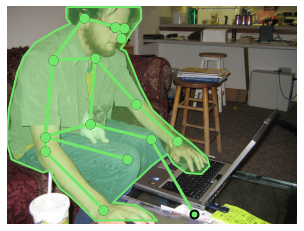

In [140]:
img = coco.loadImgs(imgId)[0]
I = io.imread(img['coco_url'])
plt.imshow(I); plt.axis('off');

ax = plt.gca()
kpsId = coco_kps.getAnnIds(imgId, iscrowd=None)
kps = coco_kps.loadAnns(kpsId)
coco_kps.showAnns(kps)
#print(kps)

capsIds = coco_caps.getAnnIds(imgIds=img['id'], iscrowd=None);
caps = coco_caps.loadAnns(capsIds)
coco_caps.showAnns(caps)

In [146]:
img

{'license': 4,
 'file_name': 'COCO_train2014_000000318857.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000318857.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-18 00:03:06',
 'flickr_url': 'http://farm4.staticflickr.com/3322/3253483755_843a54d73e_z.jpg',
 'id': 318857}

In [142]:
kps[0]

{'segmentation': [[79.48,
   366.45,
   9.29,
   337.55,
   0,
   304.52,
   0,
   270.45,
   3.1,
   226.06,
   21.68,
   145.55,
   36.13,
   110.45,
   61.94,
   79.48,
   110.45,
   50.58,
   139.35,
   37.16,
   131.1,
   27.87,
   129.03,
   9.29,
   131.1,
   1.03,
   293.16,
   1.03,
   295.23,
   8.26,
   295.23,
   27.87,
   271.48,
   59.87,
   256,
   85.68,
   249.81,
   92.9,
   261.16,
   98.06,
   274.58,
   131.1,
   293.16,
   177.55,
   320,
   228.13,
   371.61,
   275.61,
   406.71,
   302.45,
   440.77,
   333.42,
   445.94,
   352,
   428.39,
   369.55,
   395.35,
   367.48,
   366.45,
   346.84,
   353.03,
   325.16,
   321.03,
   348.9,
   294.19,
   374.71,
   280.77,
   386.06,
   233.29,
   432.52,
   284.9,
   438.71,
   317.94,
   458.32,
   330.32,
   472.77,
   241.55,
   471.74,
   194.06,
   472.77,
   140.39,
   420.13,
   117.68,
   402.58,
   102.19,
   380.9,
   93.94,
   360.26]],
 'num_keypoints': 15,
 'area': 118246.76325,
 'iscrowd': 0,
 'keypo

In [139]:
kps_ = kps[0]

In [129]:
joints_3d = np.zeros((17, 3), dtype=np.float)
joints_3d_vis = np.zeros((17, 3), dtype=np.float)
for ipt in range(17):
    joints_3d[ipt, 0] = kps_[ipt * 3 + 0]
    joints_3d[ipt, 1] = kps_[ipt * 3 + 1]
    joints_3d[ipt, 2] = 0
    t_vis = kps_[ipt * 3 + 2]
    if t_vis > 1:
        t_vis = 1
    joints_3d_vis[ipt, 0] = t_vis
    joints_3d_vis[ipt, 1] = t_vis
    joints_3d_vis[ipt, 2] = 0

In [135]:
joints_3d, joints_3d_vis

(array([[251.,  70.,   0.],
        [258.,  47.,   0.],
        [238.,  45.,   0.],
        [  0.,   0.,   0.],
        [169.,  25.,   0.],
        [194., 114.,   0.],
        [100., 118.,   0.],
        [284., 214.,   0.],
        [ 82., 318.,   0.],
        [375., 297.,   0.],
        [212., 448.,   0.],
        [182., 259.,   0.],
        [ 82., 287.,   0.],
        [316., 292.,   0.],
        [264., 337.,   0.],
        [412., 458.,   0.],
        [  0.,   0.,   0.]]),
 array([[1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 0.]]))

In [111]:
 def generate_target(joints, joints_vis):
        '''
        :param joints:  [num_joints, 3]
        :param joints_vis: [num_joints, 3]
        :return: target, target_weight(1: visible, 0: invisible)
        '''
        target_weight = np.ones((17, 1), dtype=np.float32)
        target_weight[:, 0] = joints_vis[:, 0]

        target = np.zeros((17,
                           64,
                           64),
                          dtype=np.float32)

        tmp_size = 2 * 3

        for joint_id in range(17):
            feat_stride = [4, 4]
            mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
            mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
            # Check that any part of the gaussian is in-bounds
            ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
            br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
            if ul[0] >= 64 or ul[1] >= 64 \
                    or br[0] < 0 or br[1] < 0:
                # If not, just return the image as is
                target_weight[joint_id] = 0
                continue

            # # Generate gaussian
            size = 2 * tmp_size + 1
            x = np.arange(0, size, 1, np.float32)
            y = x[:, np.newaxis]
            x0 = y0 = size // 2
            # The gaussian is not normalized, we want the center value to equal 1
            g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * 2 ** 2))

            # Usable gaussian range
            g_x = max(0, -ul[0]), min(br[0], 64) - ul[0]
            g_y = max(0, -ul[1]), min(br[1], 64) - ul[1]
            # Image range
            img_x = max(0, ul[0]), min(br[0], 64)
            img_y = max(0, ul[1]), min(br[1], 64)

            v = target_weight[joint_id]
            if v > 0.5:
                target[joint_id][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
                    g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

        return target, target_weight

In [147]:
t0, t1 = generate_target(joints_3d, joints_3d_vis)

In [149]:
t1.shape

(17, 1)

In [103]:
joints_3d

array([[251.,  70.,   0.],
       [258.,  47.,   0.],
       [238.,  45.,   0.],
       [  0.,   0.,   0.],
       [169.,  25.,   0.],
       [194., 114.,   0.],
       [100., 118.,   0.],
       [284., 214.,   0.],
       [ 82., 318.,   0.],
       [375., 297.,   0.],
       [212., 448.,   0.],
       [182., 259.,   0.],
       [ 82., 287.,   0.],
       [316., 292.,   0.],
       [264., 337.,   0.],
       [412., 458.,   0.],
       [  0.,   0.,   0.]])

In [104]:
joints_3d_vis

array([[1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [0., 0., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [0., 0., 0.]])

In [ ]:
kps[0] = list(map())

In [30]:
# get all images containing person
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds, iscrowd=None\
                       );

Railway train passenger cars with graffiti parked on a gravel lot.
A blue train sitting along side of a green forest.
Old train left out on the ground has graffiti all over it
Very old oddly colored train cars sitting in front of trees
Two abandoned blue and white train cars next to trees.


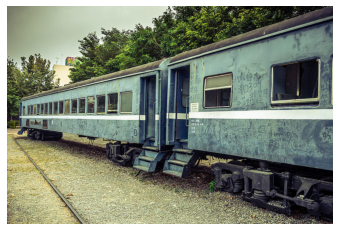

In [126]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread(img['coco_url'])
plt.imshow(I); plt.axis('off');

ax = plt.gca()
kpsIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
kps = coco_kps.loadAnns(kpsIds)
coco_kps.showAnns(kps)

capsIds = coco_caps.getAnnIds(imgIds=img['id']);
caps = coco_caps.loadAnns(capsIds)
coco_caps.showAnns(caps)

## Preprocessing text

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [18]:
def preprocess(text):
    stoplist = list(set(stopwords.words('english')))
    punctuation= list(string.punctuation)
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    
    final_text = []
    for i in tokenizer.tokenize(text):
        word = i.strip().lower() 
        if not (word in stoplist or word in punctuation or len(word) < 3):
            final_text.append(lemmatizer.lemmatize(word))
    return list(set(final_text))

In [19]:
def get_caption(caps):
    return ''.join(ann['caption'] for ann in caps)

In [20]:
preprocess(get_caption(caps))

['clear',
 'standing',
 'person',
 'camera',
 'looking',
 'toothbrush',
 'brushing',
 'scared',
 'shirt',
 'woman',
 'teeth',
 'orange',
 'mouth']